In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score
import pickle

In [2]:
# Open Pythia file
with uproot.open("../pythia/dataset.root:fastjet") as f:
    #print(f.keys())
    jet_pt = f['jet_pt'].array()
    jet_eta = f['jet_eta'].array()
    jet_phi = f['jet_phi'].array()
    jet_m = f['jet_m'].array()
    
    trk_pt = f['trk_pt'].array()
    trk_eta = f['trk_eta'].array()
    trk_phi = f['trk_phi'].array()
    trk_m = f['trk_m'].array()
    trk_q = f['trk_q'].array()
    trk_d0 = f['trk_d0'].array()
    trk_z0 = f['trk_z0'].array()

    trk_origin = f['trk_origin'].array()

In [3]:
with uproot.open("../madgraph/labels.root:labels") as f:
    #print(f.keys())
    top_px = f['top_px'].array()
    top_py = f['top_py'].array()
    top_pz = f['top_pz'].array()
    costheta = f['costheta'].array()

In [4]:
# Initialize output features

# Jet Feats
selected_jet_pt = []
selected_jet_eta = []
selected_jet_phi = []
selected_jet_m = []

# Trk Feats
selected_trk_pt = []
selected_trk_eta = []
selected_trk_phi = []
selected_trk_q = []
selected_trk_d0 = []
selected_trk_z0 = []
selected_trk_origin = []

# Label
selected_costheta = []

In [5]:
deltaR_cut = 1.0

In [6]:
#%%time
# Initialize lists for plotting
pt_partons = []
pt_fat_jets = []
deltaR = []
deltaEta = []
deltaPhi = []

unweighted_origins = []
weighted_origins = []

missing_jet=0
cutflow_deltaR=0

# Loop over all events
num_events=len(jet_pt)
for i in range(num_events):

    if i%100==0:
        print("\tProcessing: ", i, " / ", len(jet_pt), end="\r")

    # Ensure at least one fat jet
    if len(jet_pt[i])<1:
        missing_jet+=1
        continue

    # Save parton 3-Vector
    parton = vector.MomentumObject3D(px=top_px[i], py=top_py[i], pz=top_pz[i])

    # Find closest fat jet in deltaR
    delR = []
    for j in range(len(jet_pt[i])):
        delR.append(parton.deltaR(vector.MomentumObject3D(pt=jet_pt[i][j], eta=jet_eta[i][j], phi=jet_phi[i][j])))
    argmin = np.argmin(delR)

    candidate = vector.MomentumObject3D(pt=jet_pt[i][argmin], eta=jet_eta[i][argmin], phi=jet_phi[i][argmin])

    if abs(parton.deltaR(candidate))>deltaR_cut:
        cutflow_deltaR+=1
        continue

    # Closest jet in deltaR to parton is matched jet
    matched_jet = candidate

    # Fill lists for plotting
    pt_partons.append(parton.pt)
    pt_fat_jets.append(matched_jet.pt)
    deltaR.append(parton.deltaR(matched_jet))
    deltaEta.append(parton.deltaeta(matched_jet))
    deltaPhi.append(parton.deltaphi(matched_jet))
    
    # Calculate Truth Origins
    weights = trk_pt[i][argmin]
    origins = trk_origin[i][argmin]
    
    fromTop = origins==6 
    fromW = origins==24
    fromHadronic=fromTop|fromW
    
    unweighted = ak.mean(fromHadronic,axis=0)
    weighted = ak.mean(fromHadronic,axis=0,weight=weights)
    
    unweighted_origins.append(unweighted)
    weighted_origins.append(weighted)
    
    # Fill output vars
    # Jet Feats
    selected_jet_pt.append(jet_pt[i][argmin])
    selected_jet_eta.append(jet_eta[i][argmin])
    selected_jet_phi.append(jet_phi[i][argmin])
    selected_jet_m.append(jet_m[i][argmin])

    # Trk Feats
    selected_trk_pt.append(trk_pt[i][argmin])
    selected_trk_eta.append(trk_eta[i][argmin])
    selected_trk_phi.append(trk_phi[i][argmin])
    selected_trk_q.append(trk_q[i][argmin])
    selected_trk_d0.append(trk_d0[i][argmin])
    selected_trk_z0.append(trk_z0[i][argmin])
    selected_trk_origin.append(trk_origin[i][argmin])

    # Label
    selected_costheta.append(costheta[i])
    
print("\tEvents without reco jet: ", missing_jet, "/", num_events)
print("\tDeltaR Cutflow: ", cutflow_deltaR, "/", num_events)
print()

	Events without reco jet:  4846 / 10000
	DeltaR Cutflow:  2223 / 10000



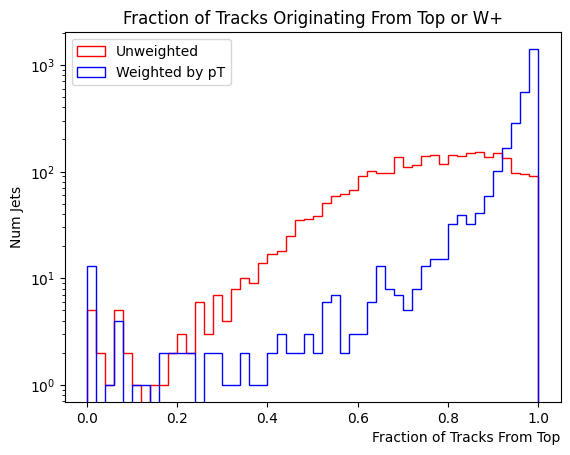

In [7]:
plt.title("Fraction of Tracks Originating From Top or W+")
plt.hist(unweighted_origins,bins=50,range=(0,1),color='r',histtype='step',label="Unweighted")
plt.hist(weighted_origins,bins=50,range=(0,1),color='b',histtype='step',label="Weighted by pT")
plt.yscale('log')
plt.ylabel('Num Jets')
plt.xlabel('Fraction of Tracks From Top',loc='right')
plt.legend()
plt.show()

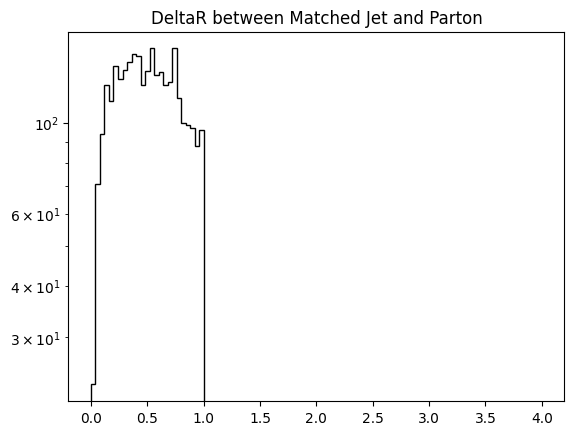

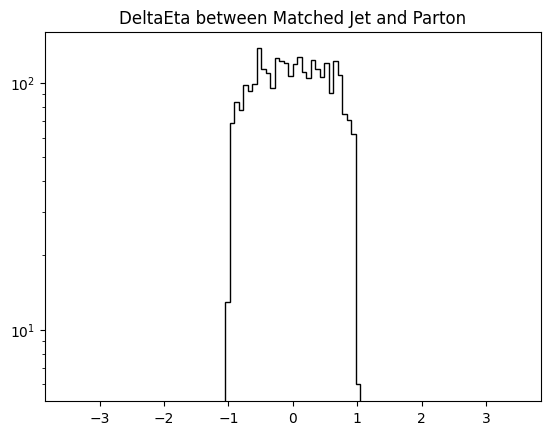

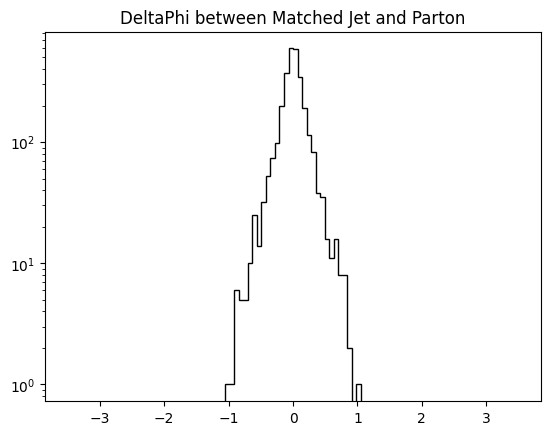

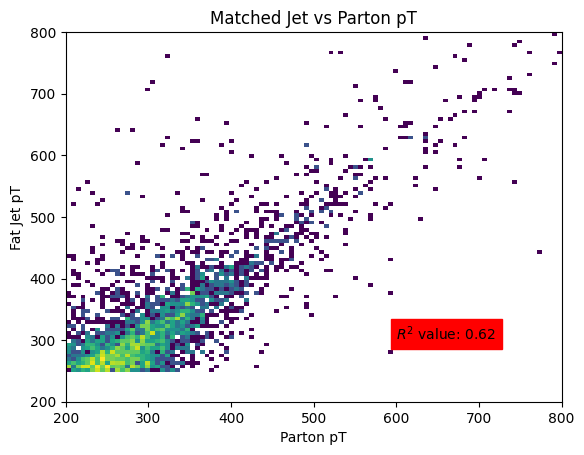

In [8]:
#fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
    
fig1, ax1 = plt.subplots()
ax1.set_title("Matched Jet vs Parton pT")
ax1.hist2d(pt_partons,pt_fat_jets, bins=100,norm=mcolors.LogNorm(),range=((200,800),(200,800)))
ax1.set_xlabel("Parton pT")
ax1.set_ylabel("Fat Jet pT")
ax1.text(600,300,"$R^2$ value: "+str(round(r2_score(pt_partons,pt_fat_jets),3)),backgroundcolor='r',color='k')

ax2.set_title("DeltaR between Matched Jet and Parton")
ax2.hist(deltaR,histtype='step',bins=100,range=(0,4),color='k')
ax2.set_yscale("log")
#ax2.legend()

ax3.set_title("DeltaEta between Matched Jet and Parton")
ax3.hist(deltaEta,histtype='step',bins=100,range=(-3.5,3.5),color='k')
ax3.set_yscale("log")
#ax3.legend()

ax4.set_title("DeltaPhi between Matched Jet and Parton")
ax4.hist(deltaPhi,histtype='step',bins=100,range=(-3.5,3.5),color='k')
ax4.set_yscale("log")
#ax4.legend()
    
plt.show()

In [9]:
"""
with uproot.recreate("preprocessed.root") as f:
    f['data'] = {
                "jet": ak.zip({"pt": selected_jet_pt,
                                   "eta": selected_jet_eta,
                                   "phi": selected_jet_phi,
                                   "m" : selected_jet_m,
                                }),
                "trk": ak.zip({"pt": selected_trk_pt,
                                   "eta": selected_trk_eta,
                                   "phi": selected_trk_phi,
                                   "q": selected_trk_q,
                                   "d0": selected_trk_d0,
                                   "z0": selected_trk_z0,
                                   "origin" : selected_trk_origin,
                                }),
                "costheta": selected_costheta,
                }
    f['data'].show()
"""

'\nwith uproot.recreate("preprocessed.root") as f:\n    f[\'data\'] = {\n                "jet": ak.zip({"pt": selected_jet_pt,\n                                   "eta": selected_jet_eta,\n                                   "phi": selected_jet_phi,\n                                   "m" : selected_jet_m,\n                                }),\n                "trk": ak.zip({"pt": selected_trk_pt,\n                                   "eta": selected_trk_eta,\n                                   "phi": selected_trk_phi,\n                                   "q": selected_trk_q,\n                                   "d0": selected_trk_d0,\n                                   "z0": selected_trk_z0,\n                                   "origin" : selected_trk_origin,\n                                }),\n                "costheta": selected_costheta,\n                }\n    f[\'data\'].show()\n'

In [10]:
# Jet Feats
jet_pt = ak.values_astype(selected_jet_pt, np.float32)
jet_eta = ak.values_astype(selected_jet_eta, np.float32)
jet_phi = ak.values_astype(selected_jet_phi, np.float32)
jet_m = ak.values_astype(selected_jet_m, np.float32)

# Trk Feats
trk_pt = ak.values_astype(selected_trk_pt, np.float32)
trk_eta = ak.values_astype(selected_trk_eta, np.float32)
trk_phi = ak.values_astype(selected_trk_phi, np.float32)
trk_q = ak.values_astype(selected_trk_q, np.float32)
trk_d0 = ak.values_astype(selected_trk_d0, np.float32)
trk_z0 = ak.values_astype(selected_trk_z0, np.float32)
trk_origin = ak.values_astype(selected_trk_origin, np.float32)

# Label
costheta = ak.values_astype(selected_costheta, np.float32)

In [11]:
jet_feat_list = [jet_pt,jet_eta,jet_phi,jet_m]
jet_feat_list = [x[:,np.newaxis] for x in jet_feat_list]
jet_feats = ak.concatenate(jet_feat_list, axis=1)

In [12]:
trk_feat_list = [trk_pt,trk_eta,trk_phi,trk_q,trk_d0,trk_z0,trk_origin]
trk_feat_list = [x[:,:,np.newaxis] for x in trk_feat_list]
trk_feats = ak.concatenate(trk_feat_list, axis=2)

In [13]:
costheta = costheta[:,np.newaxis]

In [14]:
data_dict = {"jet_feats": jet_feats,
             "trk_feats": trk_feats,
             "label": costheta,
            }

with open("data.pkl","wb") as f:
    pickle.dump(data_dict, f)